# Гревцов Марк РТ5-61Б

# Прогнозирование шансов поступления в высшее учебное заведение

В данном проекте мы будем использовать набор данных о поступлении в ВУЗ Индии. Этот проект может помочь выпускникам оценить свои шансы на поступление и выявить ключевые факторы, влияющие на этот процесс.

## Описание датасета

Датасет включает один файл `Admission_Predict.csv` с такими колонками:

- **GRE Scores (из 340)**: результат теста GRE
- **TOEFL Scores (из 120)**: результат теста TOEFL
- **University Rating (из 5)**: рейтинг университета
- **Statement of Purpose (из 5)**: оценка мотивационного письма
- **Undergraduate GPA (из 10)**: средний балл за бакалавриат
- **Research Experience (0 или 1)**: наличие исследовательского опыта
- **Chance of Admit (от 0 до 1)**: вероятность поступления

## Цель задачи

Цель данной задачи регрессии — предсказать вероятность поступления (`Chance of Admit`) на основе предоставленных признаков.


### Импорт библиотек

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
%matplotlib inline 
sns.set(style="ticks")

### Загрузка данных
Загрузим файлы датасета в помощью библиотеки Pandas.

In [71]:
data = pd.read_csv('Admission_Predict.csv')

In [72]:
# Удалим дубликаты записей, если они присутствуют
data = data.drop_duplicates()

### Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

- **Основные характеристики датасета**

In [73]:
# Первые 5 строк датасета
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [74]:
# Размер  датасета - 400 строк, 9 колонок
data.shape

(400, 9)

In [75]:
# Список колонок
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [76]:
# Список колонок с типами данных 
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

In [77]:
# Проверим наличие пустых значений
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

**Вывод**: представленный набор данных не содержит пропусков.



- **Построение графиков для понимания структуры данных**

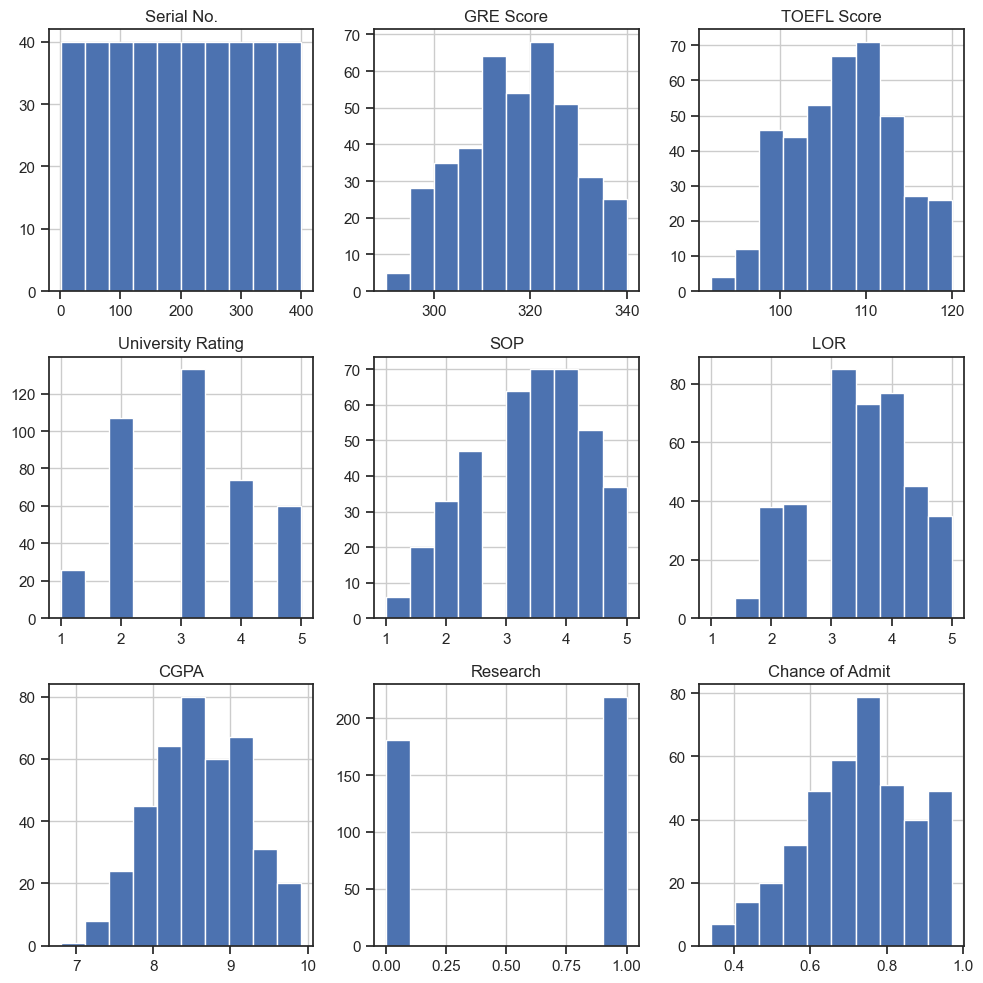

In [78]:
# Построим гистограммы для каждой переменной
data.hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

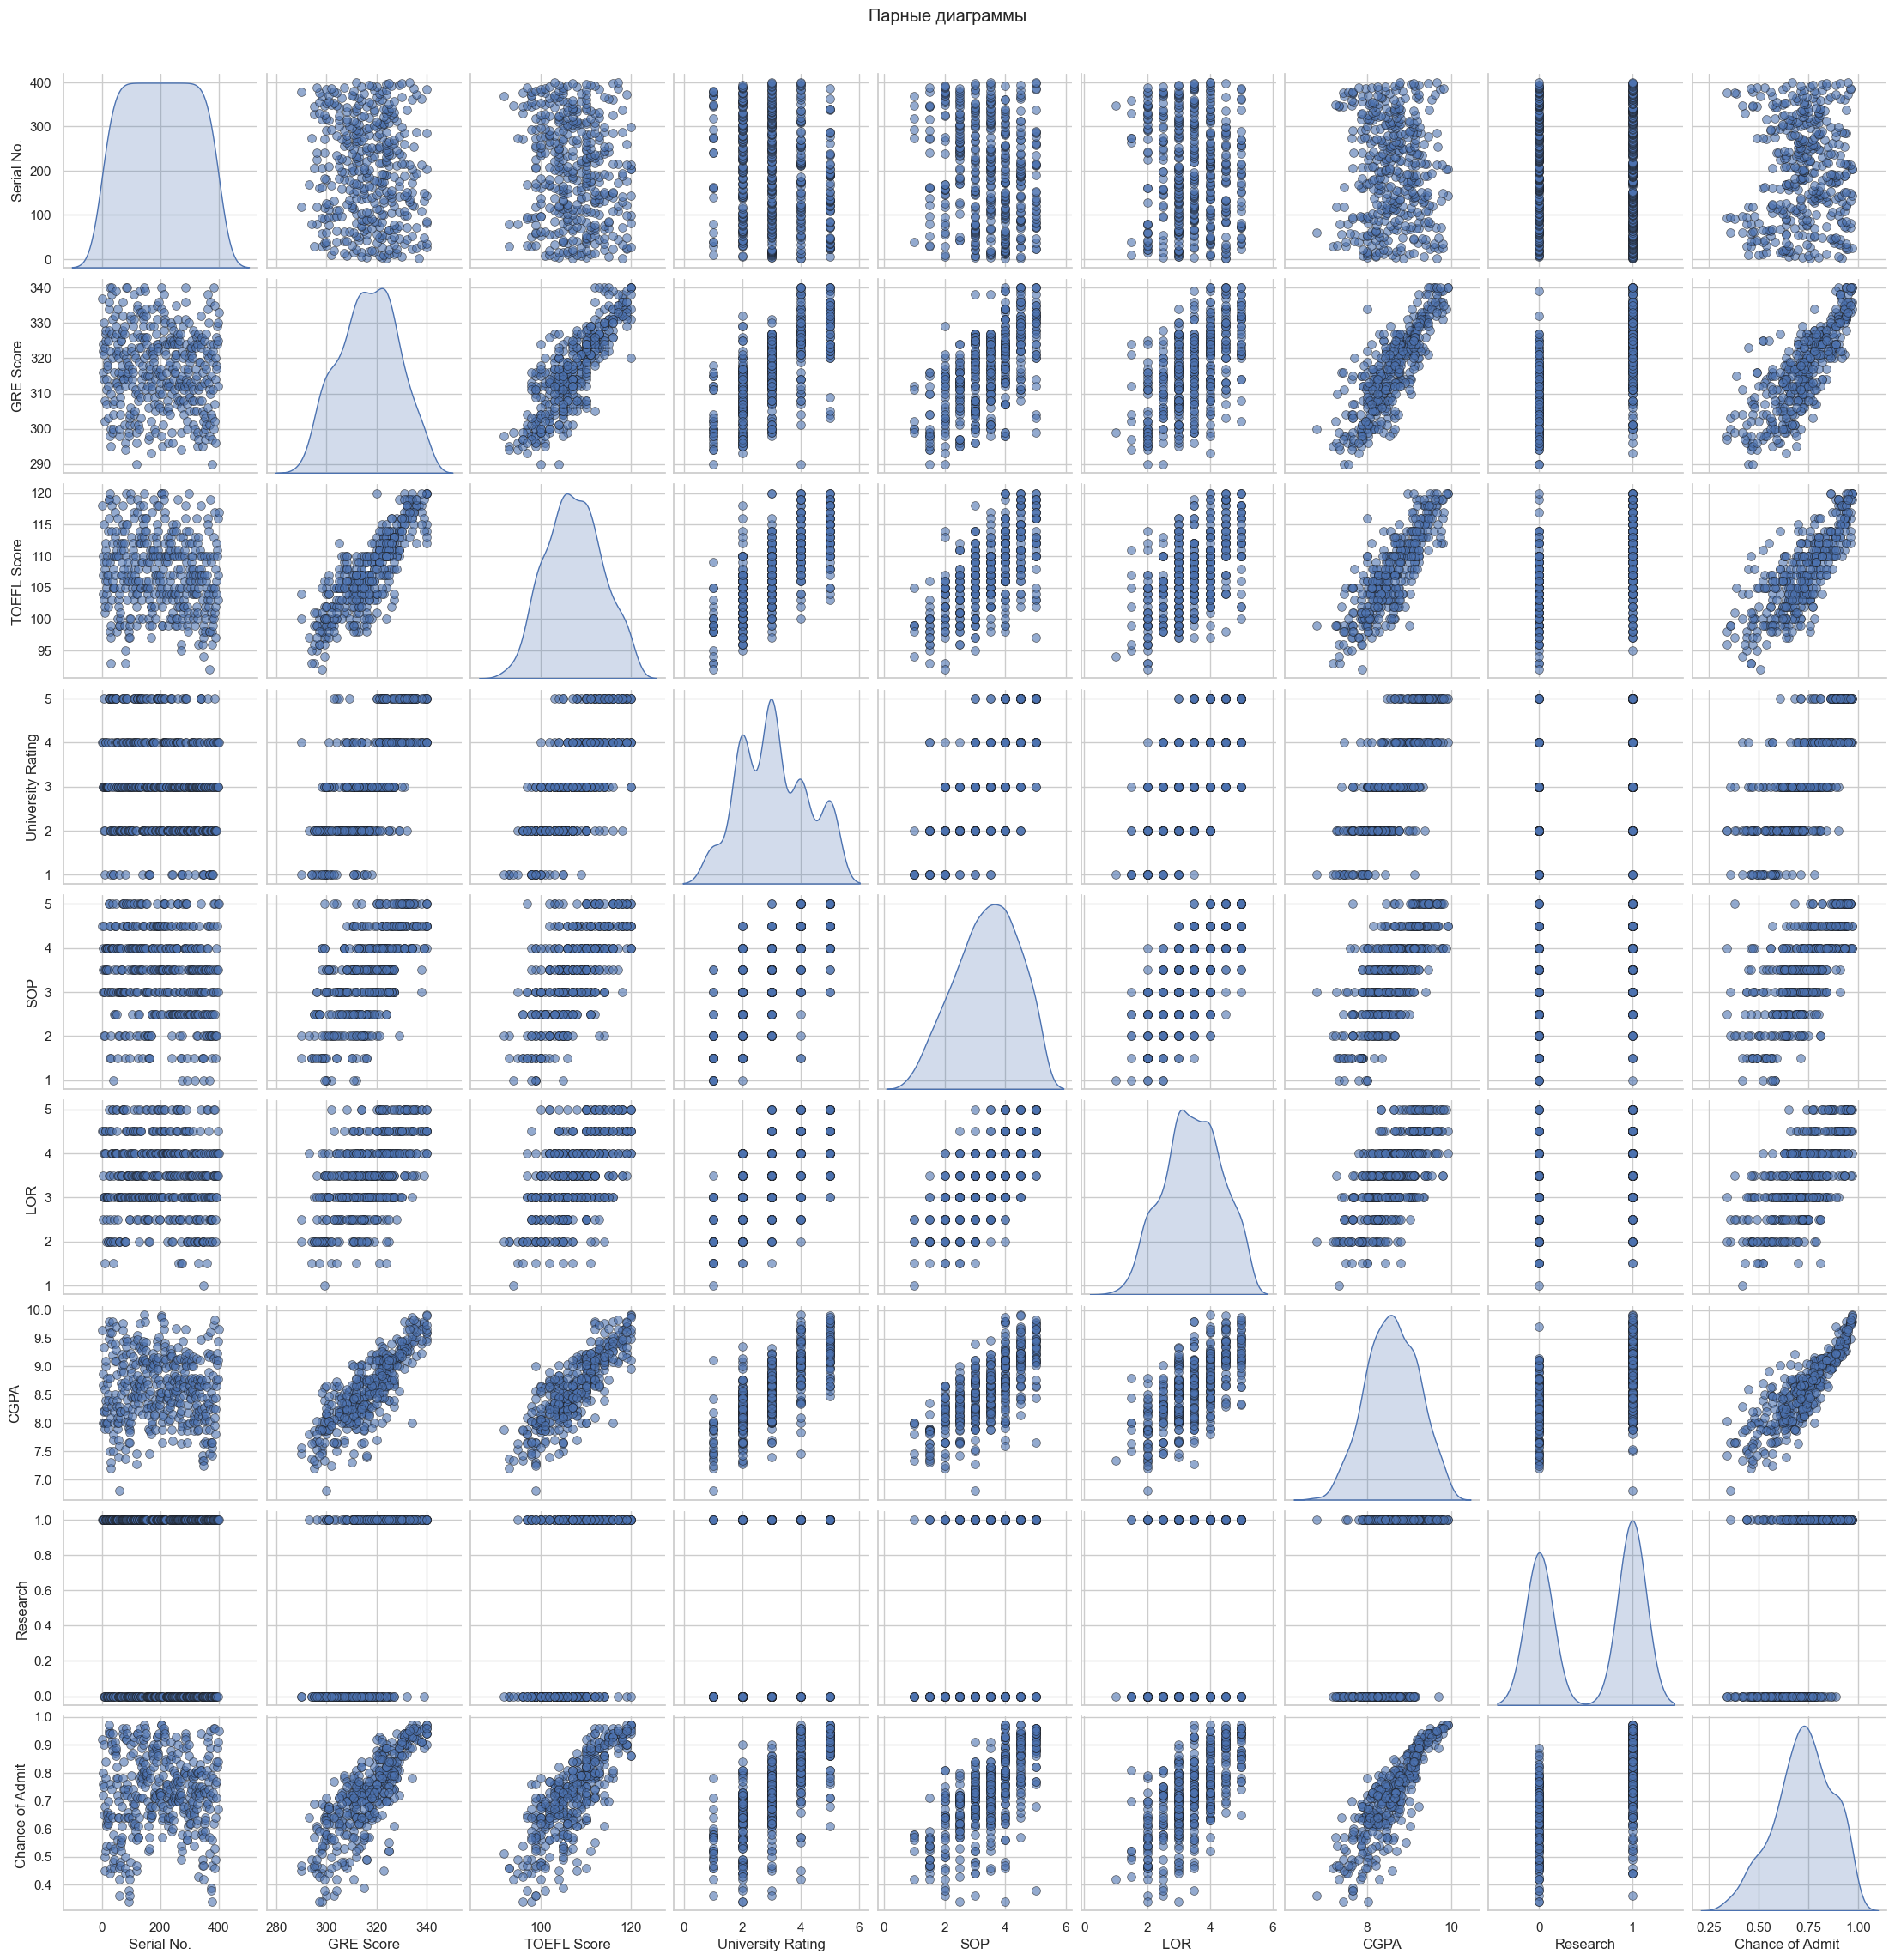

In [79]:
# Настройка стиля и палитры seaborn
sns.set(style="whitegrid")
custom_palette = sns.color_palette("viridis")

# Создание парных диаграмм 
pairplot = sns.pairplot(data, diag_kind="kde", plot_kws={"alpha": 0.6, "s": 50, "edgecolor": "k"})

# Настройка заголовка
pairplot.fig.suptitle("Парные диаграммы", y=1.02)

# Показать график
plt.show()

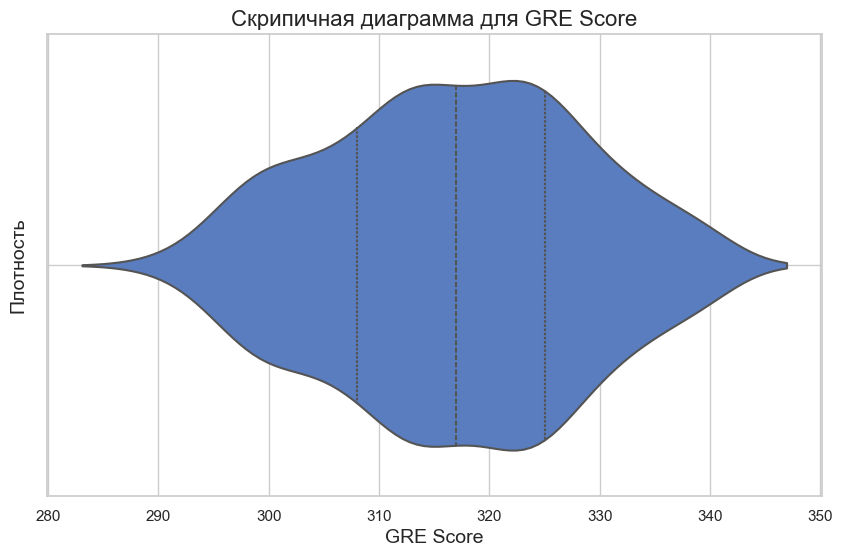

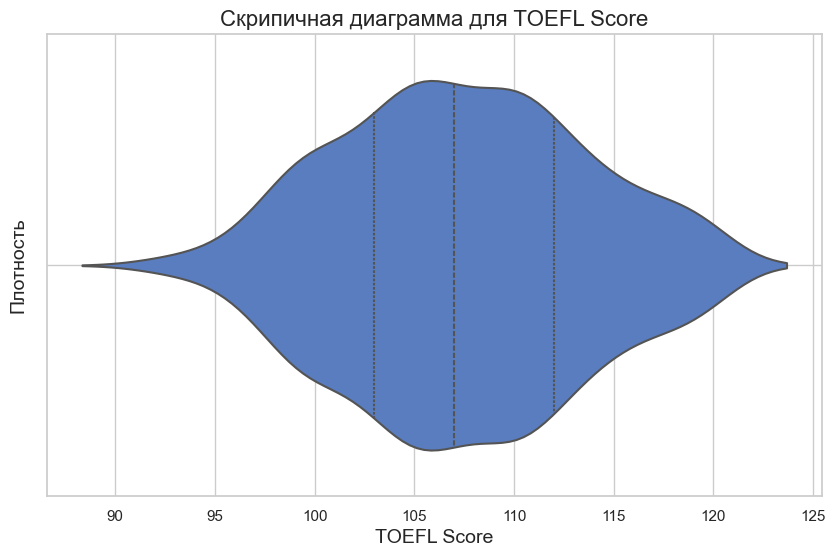

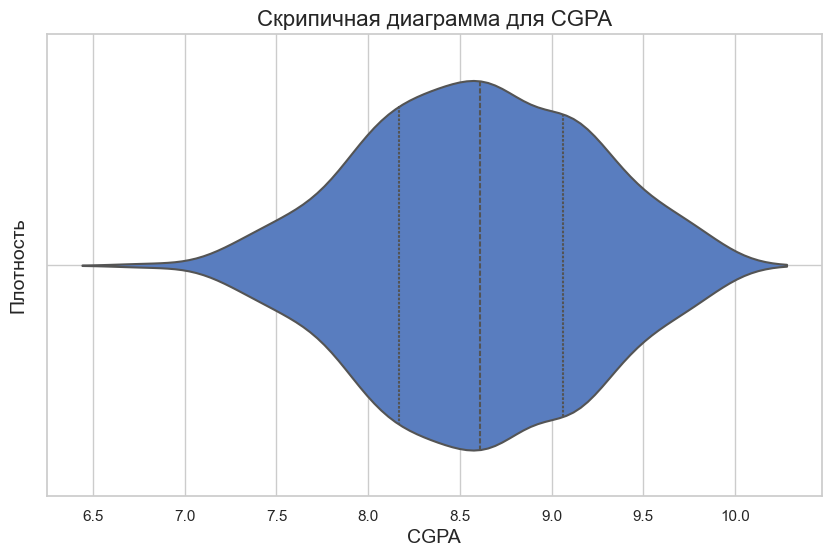

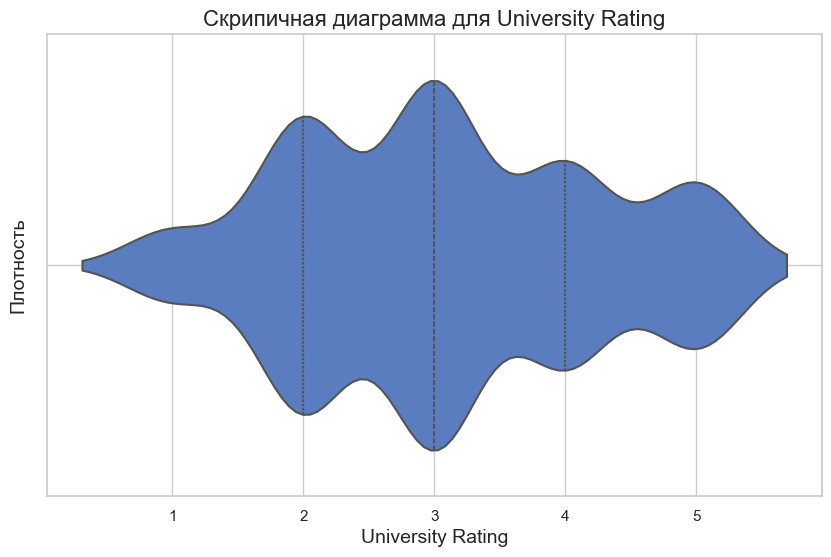

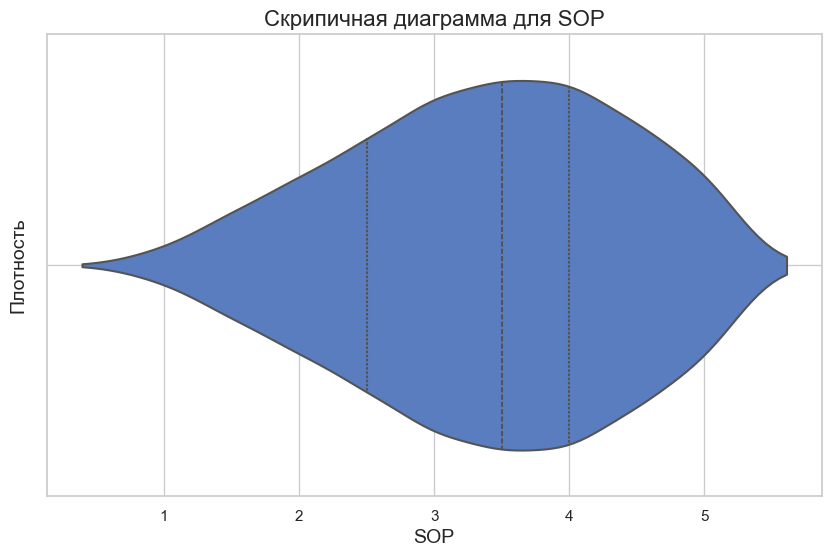

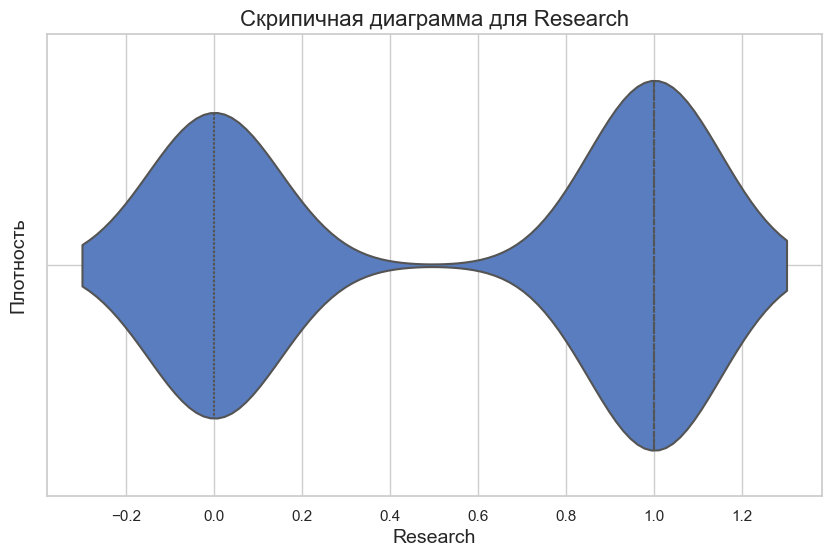

In [80]:
# Настройка стиля и палитры seaborn
sns.set(style="whitegrid", palette="muted")

# Список колонок для построения скрипичных диаграмм
columns = ['GRE Score', 'TOEFL Score', 'CGPA', 'University Rating', 'SOP', 'Research']

# Построение скрипичных диаграмм для каждой числовой колонки
for col in columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=data[col], inner="quartile", linewidth=1.5)
    plt.title(f"Скрипичная диаграмма для {col}", fontsize=16)
    plt.xlabel(col, fontsize=14)
    plt.ylabel("Плотность", fontsize=14)
    plt.grid(True)
    plt.show()

### Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей

Для построения моделей будем использовать все признаки кроме признака Serial No., потому что он определяет только порядковй номер.

Категориальные признаки присутствуют,однако их кодирования не требуется.

Вспомогательные признаки для улучшения качества моделей в данном примере мы строить не будем.
Выполним масштабирование данных. 

In [81]:
# Масштабирование данных MinMaxScaler
scale_cols_mm = ['TOEFL Score', 'CGPA', 'University Rating', 'SOP', 'Research', 'LOR ']

# Масштабирование данных StandardScaler
scale_cols_z = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'CGPA']



In [82]:
# Создаем экземпляры классов масштабирования
scaler_minmax = MinMaxScaler()
scaler_z = StandardScaler()

data_scaled_mm = data.copy()
data_scaled_mm[scale_cols_mm] = scaler_minmax.fit_transform(data[scale_cols_mm])

data_scaled_z = data.copy()
data_scaled_z[scale_cols_z] = scaler_z.fit_transform(data[scale_cols_z])


In [83]:
# Добавляем масштабированные столбцы к исходным данным с использованием метода join
data = data.join(data_scaled_mm.add_suffix('_minmax'))
data = data.join(data_scaled_z.add_suffix('_zscore'))


In [84]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,Serial No._minmax,...,Chance of Admit _minmax,Serial No._zscore,GRE Score_zscore,TOEFL Score_zscore,University Rating_zscore,SOP_zscore,LOR _zscore,CGPA_zscore,Research_zscore,Chance of Admit _zscore
0,1,337,118,4,4.5,4.5,9.65,1,0.92,1,...,0.92,1,1.762107,1.746971,0.798829,1.093864,4.5,1.764818,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76,2,...,0.76,2,0.627656,-0.067635,0.798829,0.596653,4.5,0.455151,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72,3,...,0.72,3,-0.070467,-0.562528,-0.076600,-0.397769,3.5,-1.005631,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80,4,...,0.80,4,0.453126,0.427257,-0.076600,0.099442,2.5,0.119339,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65,5,...,0.65,5,-0.244998,-0.727492,-0.952029,-1.392191,3.0,-0.653029,0,0.65


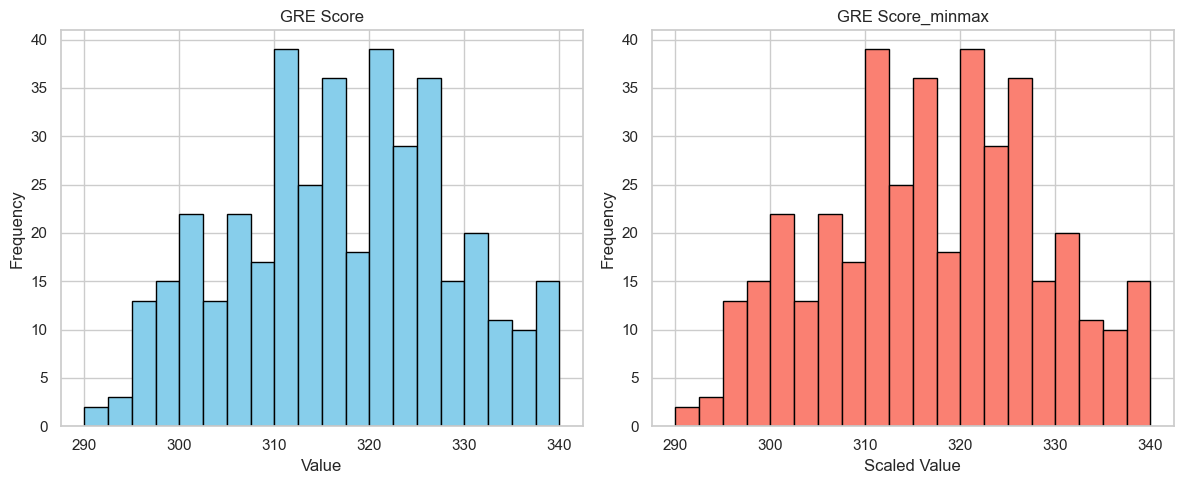

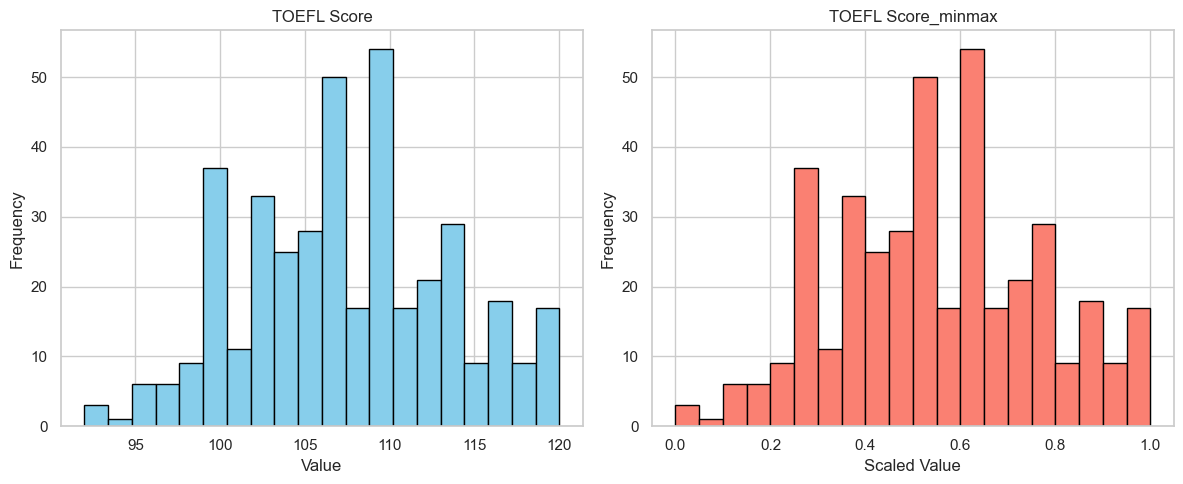

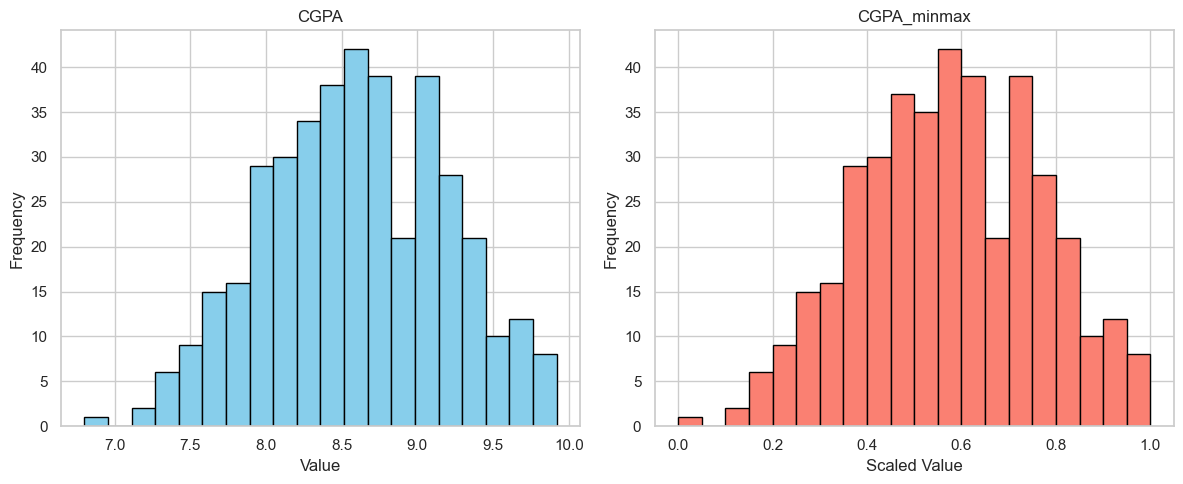

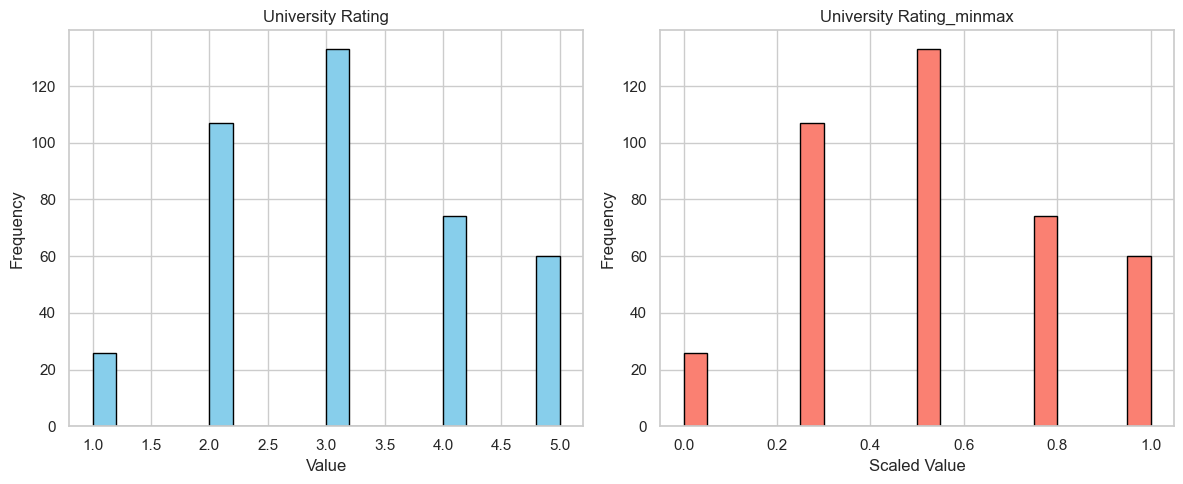

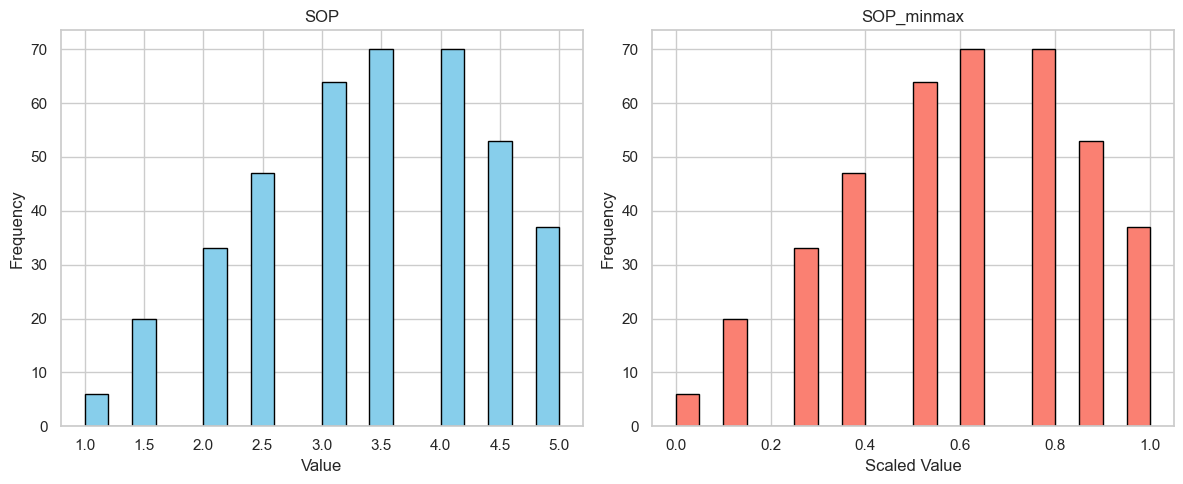

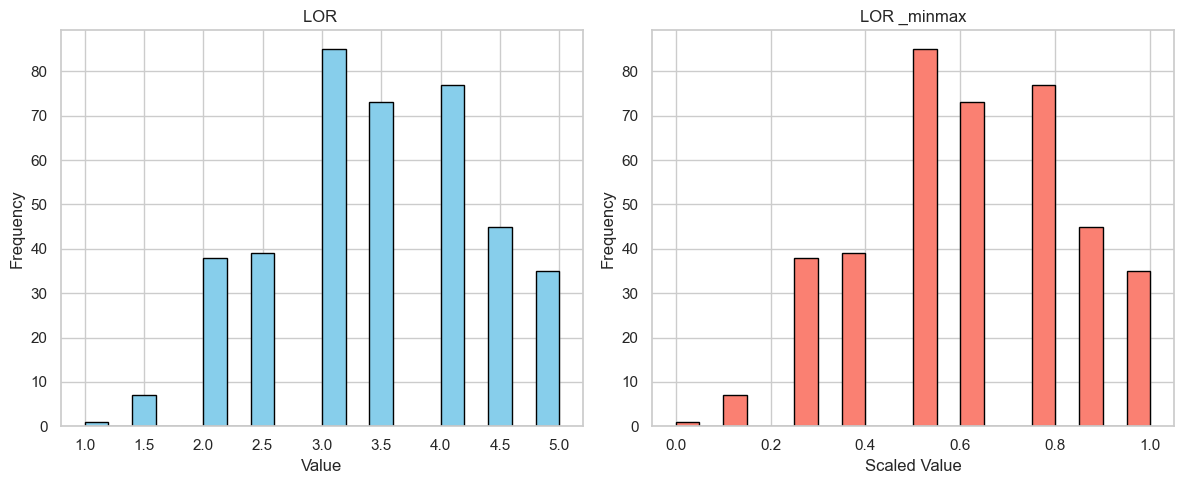

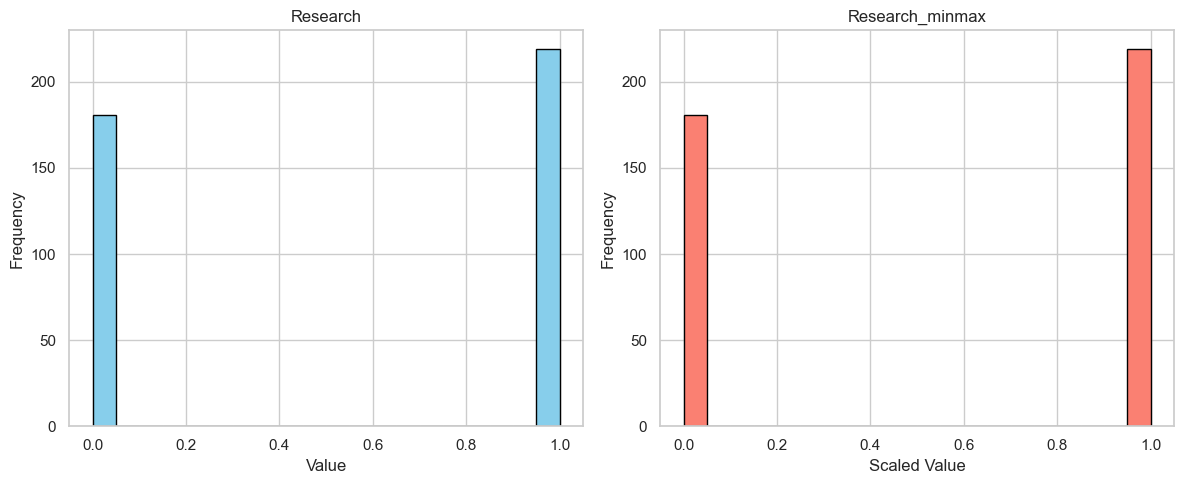

In [85]:
# Список столбцов, которые были масштабированы
scale_cols_mm = ['GRE Score', 'TOEFL Score', 'CGPA', 'University Rating', 'SOP', 'LOR ', 'Research']

# Перебираем столбцы и строим гистограммы
for col in scale_cols_mm:
    col_scaled = col + '_minmax'  # Название масштабированного столбца
    
    # Создаем график
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Гистограмма исходного столбца
    ax[0].hist(data[col], bins=20, color='skyblue', edgecolor='black')
    ax[0].set_title(col)
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Frequency')
    
    # Гистограмма масштабированного столбца
    ax[1].hist(data[col_scaled], bins=20, color='salmon', edgecolor='black')
    ax[1].set_title(col_scaled)
    ax[1].set_xlabel('Scaled Value')
    ax[1].set_ylabel('Frequency')
    
    # Отображаем графики
    plt.tight_layout()
    plt.show()

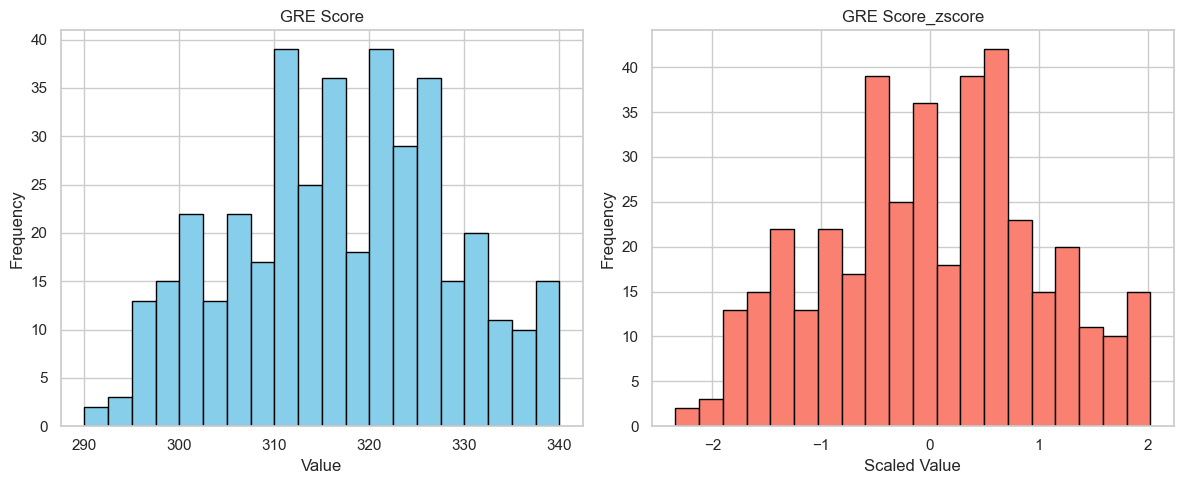

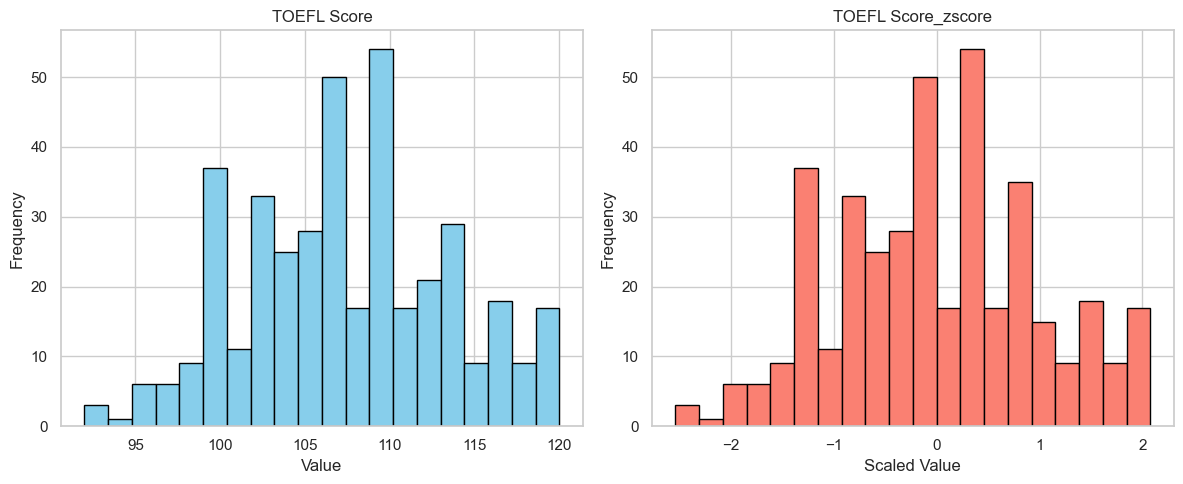

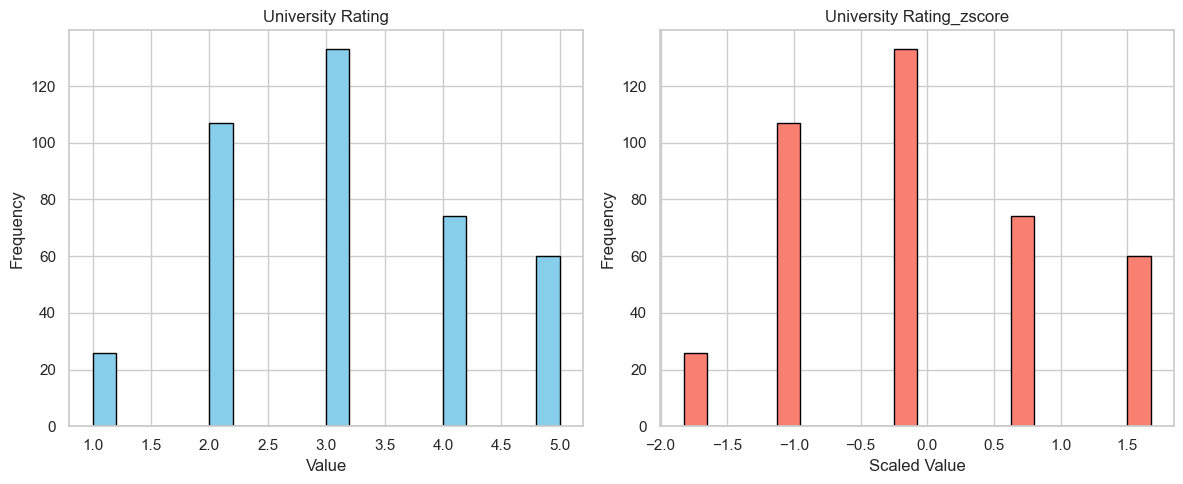

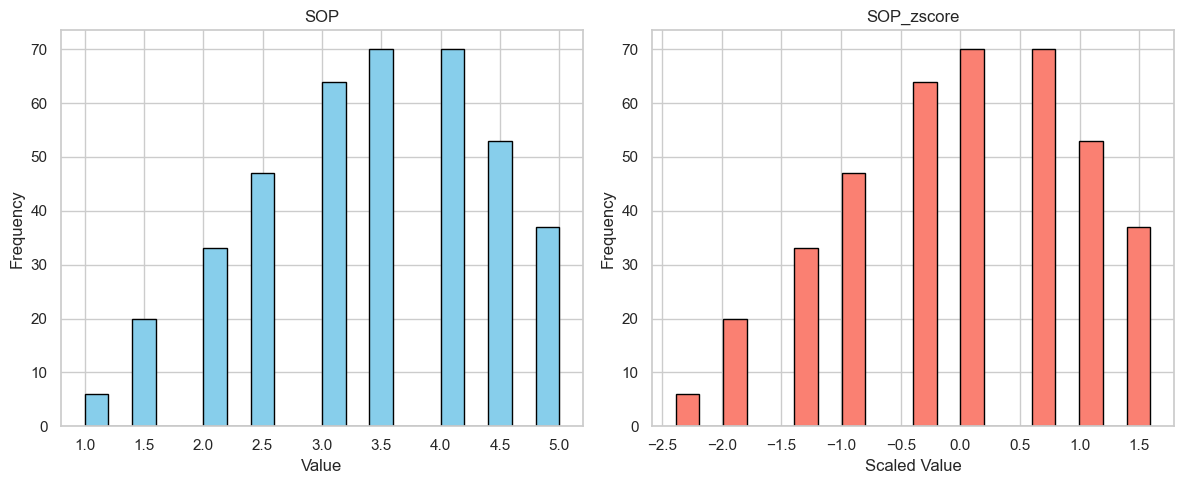

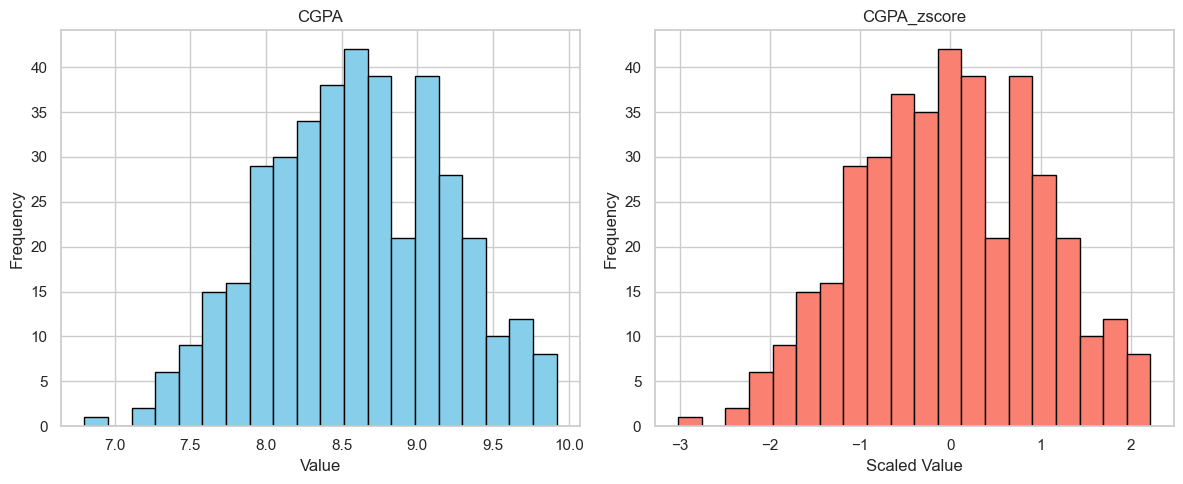

In [86]:
# Список столбцов, которые были масштабированы
scale_cols_z = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'CGPA']

# Перебираем столбцы и строим гистограммы
for col in scale_cols_z:
    col_scaled = col + '_zscore'  # Название масштабированного столбца
    
    # Создаем график
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Гистограмма исходного столбца
    ax[0].hist(data[col], bins=20, color='skyblue', edgecolor='black')
    ax[0].set_title(col)
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Frequency')
    
    # Гистограмма масштабированного столбца
    ax[1].hist(data[col_scaled], bins=20, color='salmon', edgecolor='black')
    ax[1].set_title(col_scaled)
    ax[1].set_xlabel('Scaled Value')
    ax[1].set_ylabel('Frequency')
    
    # Отображаем графики
    plt.tight_layout()
    plt.show()

### Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

In [87]:
print(data.columns)


Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit ', 'Serial No._minmax',
       'GRE Score_minmax', 'TOEFL Score_minmax', 'University Rating_minmax',
       'SOP_minmax', 'LOR _minmax', 'CGPA_minmax', 'Research_minmax',
       'Chance of Admit _minmax', 'Serial No._zscore', 'GRE Score_zscore',
       'TOEFL Score_zscore', 'University Rating_zscore', 'SOP_zscore',
       'LOR _zscore', 'CGPA_zscore', 'Research_zscore',
       'Chance of Admit _zscore'],
      dtype='object')


In [88]:
corr_cols_1 = scale_cols_z + ['Chance of Admit ']
corr_cols_1

['GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'CGPA',
 'Chance of Admit ']

In [89]:
scale_cols_postfix = [x+'_zscore' for x in scale_cols_z]
corr_cols_2 = scale_cols_postfix + ['Chance of Admit ']
corr_cols_2

['GRE Score_zscore',
 'TOEFL Score_zscore',
 'University Rating_zscore',
 'SOP_zscore',
 'CGPA_zscore',
 'Chance of Admit ']

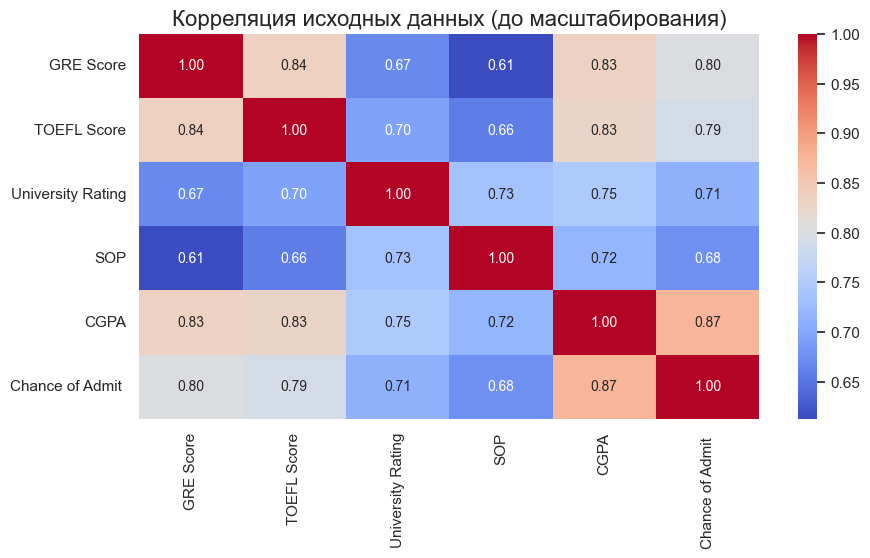

In [90]:
# Создаем тепловую карту
fig, ax = plt.subplots(figsize=(10, 5))
heatmap = sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f', cmap='coolwarm')

# Настройка заголовка
ax.set_title('Корреляция исходных данных (до масштабирования)', fontsize=16)

# Настройка шрифтов аннотаций
for text in heatmap.texts:
    text.set_fontsize(10)

# Отображаем тепловую карту
plt.show()

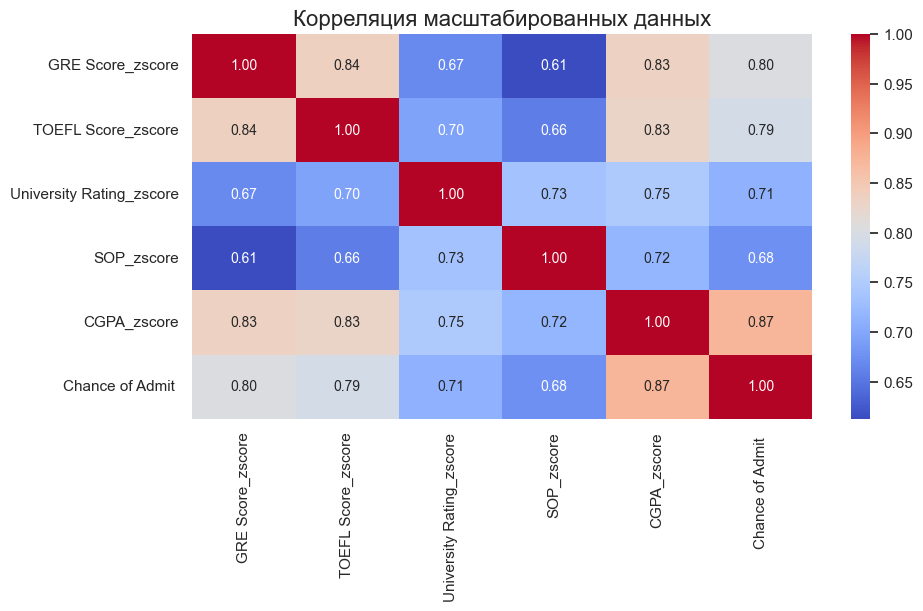

In [91]:
# Создаем тепловую карту для масштабированных данных
fig, ax = plt.subplots(figsize=(10, 5))
heatmap = sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f', cmap='coolwarm')

# Настройка заголовка
ax.set_title('Корреляция масштабированных данных', fontsize=16)

# Настройка шрифтов аннотаций
for text in heatmap.texts:
    text.set_fontsize(10)

# Отображаем тепловую карту
plt.show()

#### На основе корреляционной матрицы можно сделать следующие выводы:

- Корреляционные матрицы для исходных и масштабированных данных совпадают.
- Целевой признак классификации "Chance of Admit" наиболее сильно коррелирует с CGPA (0.87), баллом  GRE (0,8) и TOEFL (0.79). Однако между этими тремя признаками есть сильная корреляция, поэтому возьмем только признак "GRE Score", так как он имеет самую большую корреляцию. 
- Также высокая корреляция с целевым признаком наблюдается у признака "University Rating" (0.71), что указывает на его значимость при построении модели.
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой линейной зависимости между исходными признаками и целевым признаком, что подтверждает возможность построения модели машинного обучения на основе этих данных.

Таким образом, на основании корреляционной матрицы можно сделать вывод о том, что данные обладают информационной ценностью и могут быть использованы для построения модели прогнозирования шанса поступления.

### Выбор метрик для последующей оценки качества моделей:
- Mean absolute error (MAE) - средняя абсолютная ошибка
- Mean squared error (MSE) - средняя квадратичная ошибка
- Root Mean Squared Error (RMSE) - корень из средняя квадратичная ошибки
- R2 - коэффициент детерминации

Средняя абсолютная ошибка **MAE** и средняя квадратичная ошибка **MSE** выбраны, так как они предоставляют информацию о точности прогнозов модели и позволяют оценить направленность и величину ошибок. **MAE** позволяет оценить среднюю абсолютную величину ошибки между фактическими и прогнозными значениями, в то время как MSE учитывает квадраты отклонений и обращается больше внимания на большие ошибки.

Root Mean Squared Error **RMSE** включен как дополнительная метрика, так как он предоставляет информацию о среднем квадратическом отклонении прогнозов модели от фактических значений. **RMSE** выражен в тех же единицах, что и целевая переменная, что делает его легче интерпретируемым по сравнению с **MSE**.

Коэффициент детерминации **R2** выбран, так как он предоставляет информацию о том, насколько хорошо модель объясняет вариацию в целевой переменной. **R2** принимает значения от 0 до 1, где 1 означает идеальное соответствие между прогнозами модели и фактическими значениями, а 0 означает отсутствие вариации в целевой переменной, объясняемой моделью. Таким образом, **R2** помогает оценить общую эффективность модели в объяснении вариации в данных."

### Выбор моделей:
- Линейная регрессия
- Метод ближайших соседей
- Методопорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

In [92]:
# На основе масштабированных данных выделим обучающую и тестовую выборки
# Создаем словарь с ключами и значениями для DataFrame
data_dict = {"GRE Score_zscore": data['GRE Score_zscore'], "University Rating_zscore": data['University Rating_zscore']}

# Создаем DataFrame из словаря
df_scaled = pd.DataFrame(data_dict)

# Теперь, когда у нас есть DataFrame с масштабированными данными, мы можем разделить его на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_scaled, data['Chance of Admit '], random_state=1)


In [93]:
#размеры выборок
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((300, 2), (300,), (100, 2), (100,))

### Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.


In [94]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [95]:
# from torchmetrics import MetricLogger
# # Сохранение метрик
# regrMetricLogger = MetricLogger()
regrMetricLogger = pd.DataFrame(columns=['MODEL', 'METRIC', 'VALUE'])


In [96]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, Y_pred)
    mse = mean_squared_error(y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, Y_pred)

    regrMetricLogger.loc[len(regrMetricLogger)] = [model_name, 'MAE', mae]
    regrMetricLogger.loc[len(regrMetricLogger)] = [model_name, 'MSE', mse]
    regrMetricLogger.loc[len(regrMetricLogger)] = [model_name, 'RMSE', rmse]
    regrMetricLogger.loc[len(regrMetricLogger)] = [model_name, 'R2', r2]
   
    print('{} \t MAE={}, MSE={}, RMSE={}, R2={}'.format(
        model_name, round(mae, 3), round(mse, 3), round(rmse, 3), round(r2, 3)))

In [97]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

LR 	 MAE=0.06, MSE=0.007, RMSE=0.082, R2=0.708
KNN_5 	 MAE=0.066, MSE=0.008, RMSE=0.09, R2=0.646
SVR 	 MAE=0.07, MSE=0.008, RMSE=0.09, R2=0.646
Tree 	 MAE=0.073, MSE=0.01, RMSE=0.099, R2=0.57
RF 	 MAE=0.067, MSE=0.008, RMSE=0.09, R2=0.641
GB 	 MAE=0.065, MSE=0.008, RMSE=0.09, R2=0.643


### Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.

In [98]:
n_range = np.array(range(1,10,1))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}]

In [99]:
%%time
regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(X_train, y_train)

CPU times: total: 93.8 ms
Wall time: 332 ms


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}],
             scoring='neg_mean_squared_error')

In [100]:
# Лучшая модель
regr_gs.best_estimator_

KNeighborsRegressor(n_neighbors=9)

In [101]:
# Лучшее значение параметров
regr_gs.best_params_

{'n_neighbors': 9}

In [102]:
regr_gs_best_params_txt = str(regr_gs.best_params_['n_neighbors'])
regr_gs_best_params_txt

'9'

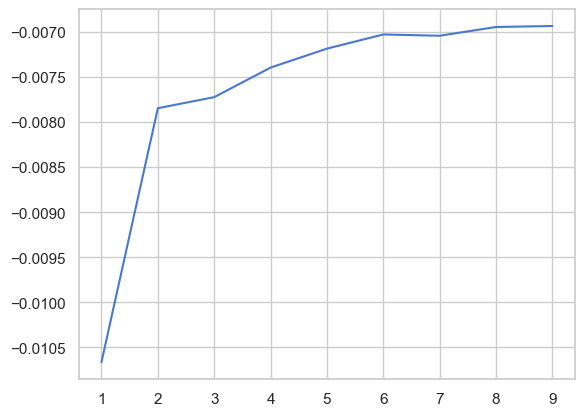

In [103]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs.cv_results_['mean_test_score'])

### Построение моделей с учетом подбора гиперпараметра. Сравнение качества полученных моделей с качеством baseline-моделей.

In [104]:
regr_models_grid = {'KNN_5':KNeighborsRegressor(n_neighbors=5), 
                    str('KNN_'+regr_gs_best_params_txt):regr_gs.best_estimator_}

In [105]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

KNN_5 	 MAE=0.066, MSE=0.008, RMSE=0.09, R2=0.646
KNN_9 	 MAE=0.063, MSE=0.008, RMSE=0.087, R2=0.665


### Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

In [106]:
# Метрики качества модели
regr_metrics = regrMetricLogger['METRIC'].unique()
regr_metrics

array(['MAE', 'MSE', 'RMSE', 'R2'], dtype=object)

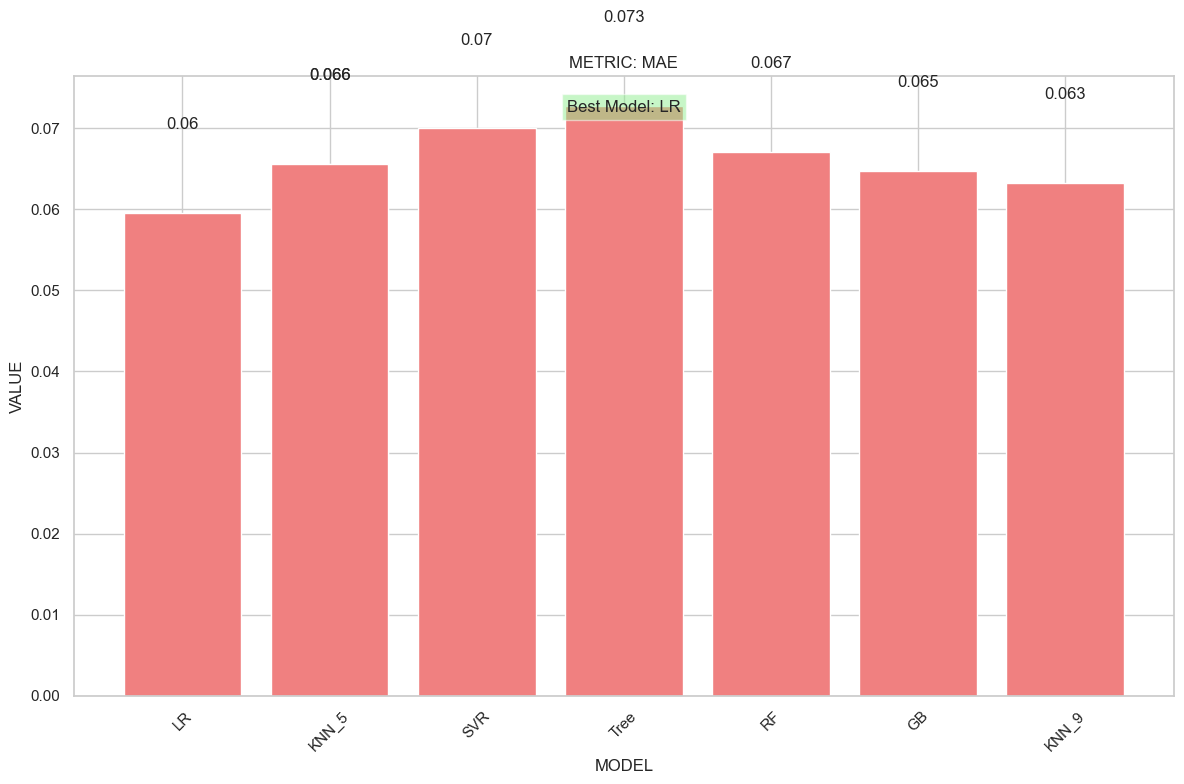

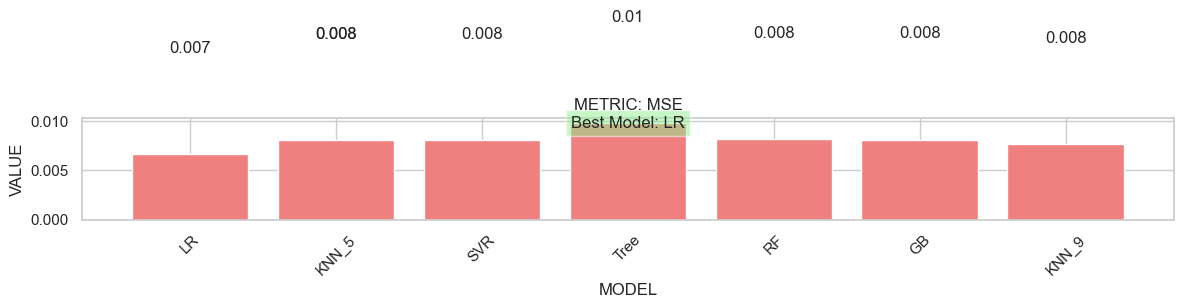

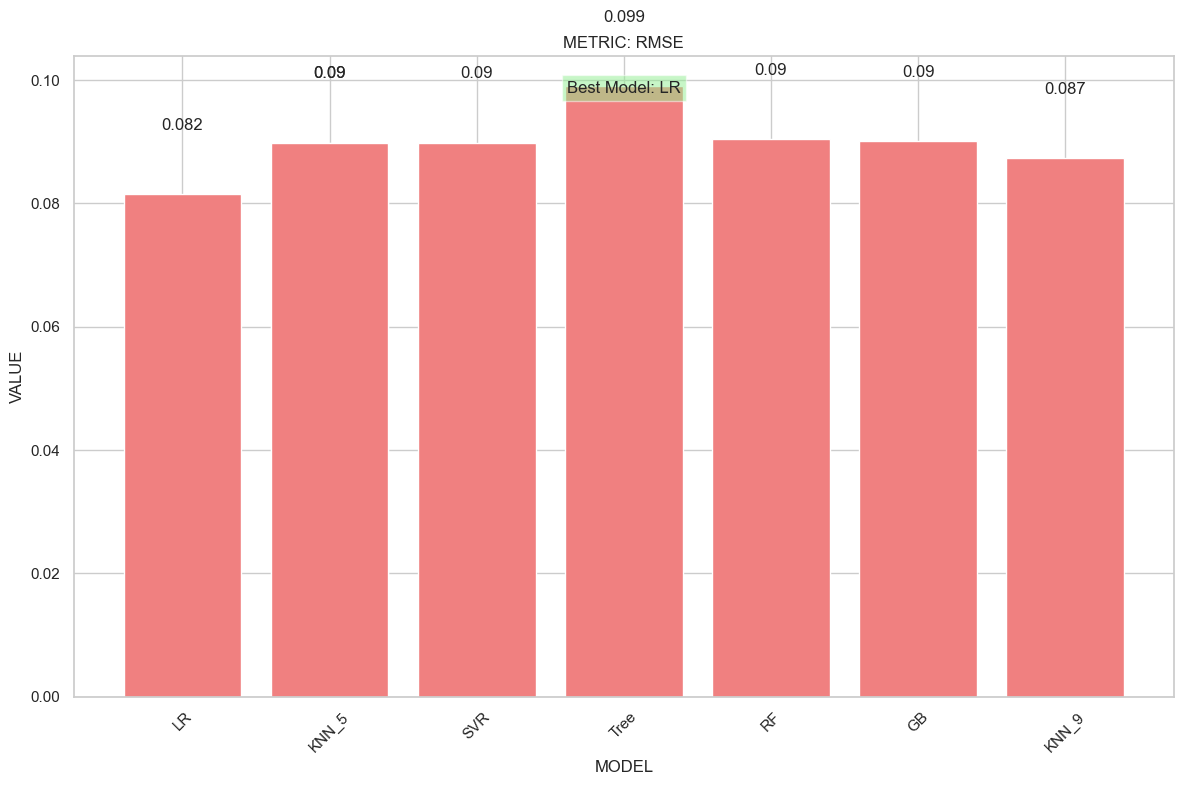

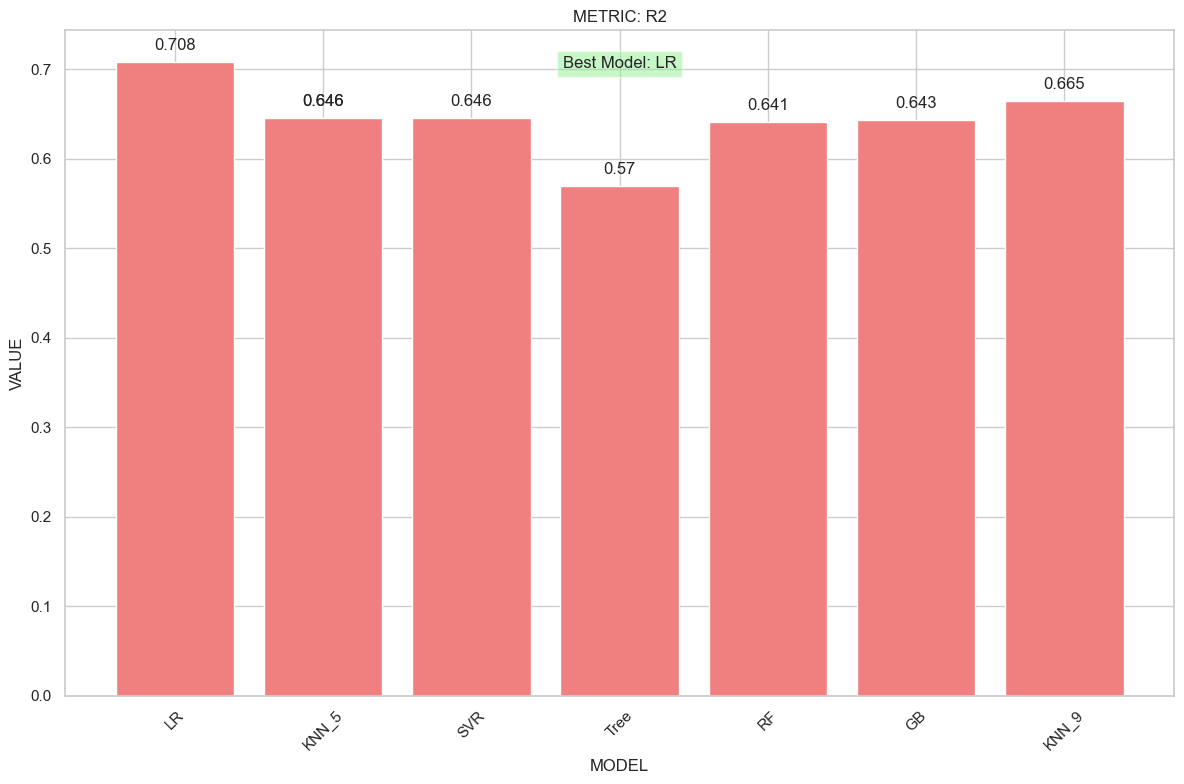

In [107]:
def plot_metric(regrMetricLogger, metric_name):
    # Фильтрация DataFrame для отображения только интересующей метрики
    filtered_df = regrMetricLogger[regrMetricLogger['METRIC'] == metric_name][['MODEL', 'VALUE']]
    
    # Создание столбчатой диаграммы
    plt.figure(figsize=(12, 8))  # Увеличиваем размер поля графика
    bars = plt.bar(filtered_df['MODEL'], filtered_df['VALUE'], color='lightcoral') 
    
    # Добавление значений на столбцах
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

    plt.xlabel('MODEL')
    plt.ylabel('VALUE')
    plt.title(f'METRIC: {metric_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Выводим название модели с лучшим значением метрики
    best_model = filtered_df.loc[filtered_df['VALUE'].idxmin() if metric_name in ['MAE', 'MSE', 'RMSE'] else filtered_df['VALUE'].idxmax()]['MODEL']
    plt.text(0.5, 0.95, f'Best Model: {best_model}', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='lightgreen', alpha=0.5))
    
    plt.show()

# Пример использования функции для каждой из метрик
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
for metric in metrics:
    plot_metric(regrMetricLogger, metric)


# Вывод

В ходе данной работы была выполнена оценка качества моделей машинного обучения для задачи регрессии на основе нескольких метрик:

- **Mean Absolute Error (MAE)**: средняя абсолютная ошибка
- **Mean Squared Error (MSE)**: средняя квадратичная ошибка
- **Root Mean Squared Error (RMSE)**: корень из средней квадратичной ошибки
- **R2 (R-квадрат)**: коэффициент детерминации

Для каждой из этих метрик были построены столбчатые диаграммы, отражающие значения метрик для различных моделей. Была выделена лучшая модель для каждой метрики, которая показала наилучший результат.

Анализируя результаты, можно сделать следующие выводы:

- **Линейная регрессия** оказалась лучшей моделью по всем метрикам. Это говорит о том, что в данном наборе данных линейная зависимость между признаками и целевой переменной достаточно хорошо описывается линейной моделью.
- **K ближайших соседей (KNN)** также показал неплохие результаты, однако хуже, чем линейная регрессия. Возможно, это связано с тем, что в данных нет четких групп или кластеров, которые можно было бы учесть при прогнозировании.
- **Деревья решений, случайный лес и градиентный бустинг** показали себя хуже по сравнению с линейной регрессией и KNN. Вероятно, данные не содержат достаточно сложных зависимостей, которые могли бы быть выявлены более сложными моделями.

Таким образом, в данной задаче регрессии наилучшие результаты достигнуты с использованием **линейной регрессии**.
